In [1]:
!nvidia-smi

Thu Dec  9 12:23:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### loading libraries

In [3]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import imageio
import shutil
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import layers
from tensorflow.keras import models

from IPython.display import clear_output

In [4]:
import random
import cv2
import albumentations as A

In [6]:
print(A.__version__)

1.1.0


In [7]:
#load dataset 
path = "/content/drive/MyDrive/lane_detection.zip"

zip_ref = zipfile.ZipFile(path, 'r')

zip_ref.extractall()
zip_ref.close()

In [8]:
#search for non image files

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'/content/lane_detection'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  labels
file  /content/lane_detection/labels/.DS_Store  has an invalid extension  ds_store
file  /content/lane_detection/labels/.DS_Store  is not a valid image file
processing class directory  images
file  /content/lane_detection/images/.DS_Store  has an invalid extension  ds_store
file  /content/lane_detection/images/.DS_Store  is not a valid image file
processing class directory  .DS_Store
*** WARNING*** you have files in  /content/lane_detection  it should only contain sub directories
improper image files are listed below
/content/lane_detection/labels/.DS_Store
/content/lane_detection/images/.DS_Store


In [9]:
bad_ext_list

['/content/lane_detection/labels/.DS_Store',
 '/content/lane_detection/images/.DS_Store']

In [10]:
os.remove('/content/lane_detection/images/.DS_Store')
os.remove('/content/lane_detection/labels/.DS_Store')

In [5]:
#Loading the images and corresponding masks
images = os.listdir('/content/lane_detection/images')
masks = os.listdir('/content/lane_detection/labels')

In [6]:
# Visualization function
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

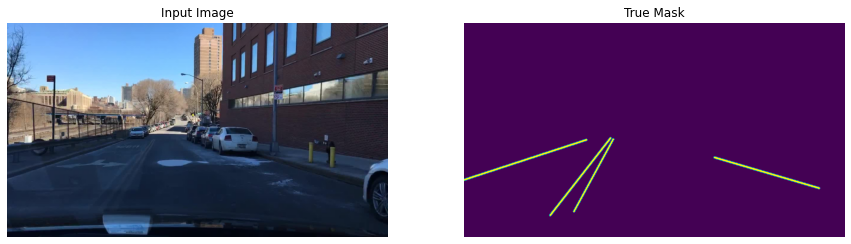

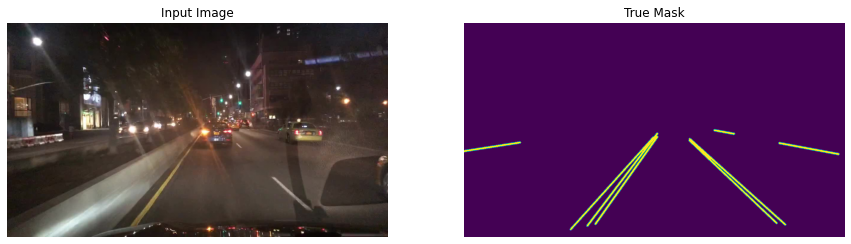

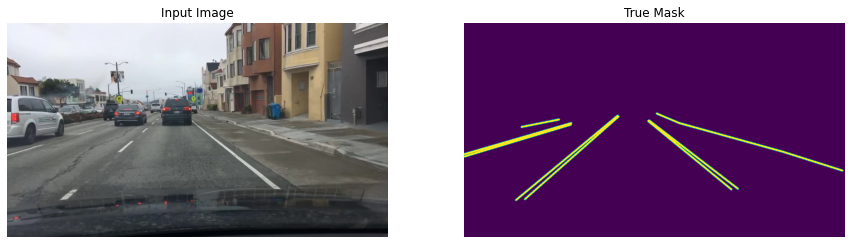

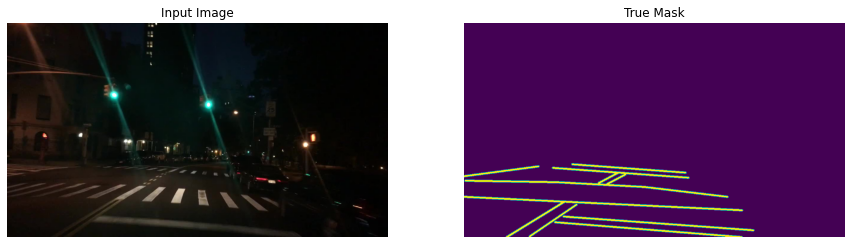

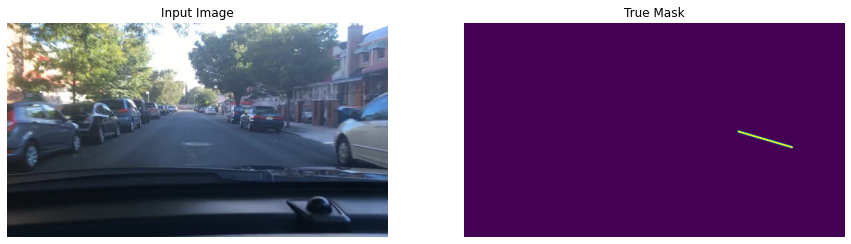

In [6]:
#Let us visualize 5 images and their corresponding masks
i=0
for image, mask in zip(images, masks):
    #print(image)
    #print(mask)
    img = cv2.imread(os.path.join('/content/lane_detection/images', image))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    m = cv2.imread(os.path.join('/content/lane_detection/labels', mask))
    m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
    m = tf.expand_dims(m, axis=-1)
    display([rgb, m])
    i+=1
    if i == 5:
        break

In [14]:
#Checking the length of the dataset
print(len(masks))

501


In [16]:
os.makedirs('bddk_dataset',exist_ok=True)

In [17]:
#split data in train,test,val
import splitfolders
splitfolders.ratio("lane_detection", output="bddk_dataset", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 1002 files [00:00, 3430.27 files/s]


In [18]:
train_images = os.listdir('./bddk_dataset/train/images')
val_images=os.listdir('./bddk_dataset/val/images')
test_images = os.listdir('./bddk_dataset/test/images')


In [19]:
print("train data size",len(train_images))
print("val data size",len(val_images))
print("test data size",len(test_images))

train data size 400
val data size 50
test data size 51


#### Training model on the train set and using val set for cross validation

In [20]:
#Setting up the dataset for model training

train_images = os.listdir('./bddk_dataset/train/images')

X_train=[]
y_train=[]

for image in train_images:
    X_train.append(os.path.join('./bddk_dataset/train/images', image))
    y_train.append(os.path.join('./bddk_dataset/train/labels', image))
    
val_images = os.listdir('./bddk_dataset/val/images')

X_val=[]
y_val=[]

for image in val_images:
    X_val.append(os.path.join('./bddk_dataset/val/images', image))
    y_val.append(os.path.join('./bddk_dataset/val/labels', image))

train_image_files = tf.constant(X_train)
train_mask_files = tf.constant(y_train)
t_dataset = tf.data.Dataset.from_tensor_slices((train_image_files, train_mask_files))

val_image_files = tf.constant(X_val)
val_mask_files = tf.constant(y_val)
v_dataset = tf.data.Dataset.from_tensor_slices((val_image_files, val_mask_files))

In [7]:
#Function to read images and masks and convert the to tensors
def process_path(image_path,mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image,dtype=tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=3)
    mask = mask[:,:,0]
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.convert_image_dtype(mask,dtype=tf.float32)
    return image,mask

In [8]:
#Function to normalize images
def normalize(input_image, input_mask):
    input_image = input_image/ 255.0
    return input_image, input_mask

In [9]:
@tf.function
def load_image_train(image,mask):
    input_image = tf.image.resize(image, (512, 512), method='nearest')
    input_mask = tf.image.resize(mask, (512, 512), method='nearest')
        
        
    input_image, input_mask = normalize(input_image, input_mask)
        
    return input_image, input_mask

In [10]:

def load_image_test(image,mask):
    input_image = tf.image.resize(image, (512, 512), method='nearest')
    input_mask = tf.image.resize(mask, (512, 512), method='nearest')

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [26]:
processed_trainset = t_dataset.map(process_path)
train_dataset = processed_trainset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
processed_val_set = v_dataset.map(process_path)
val_dataset = processed_val_set.map(load_image_test)

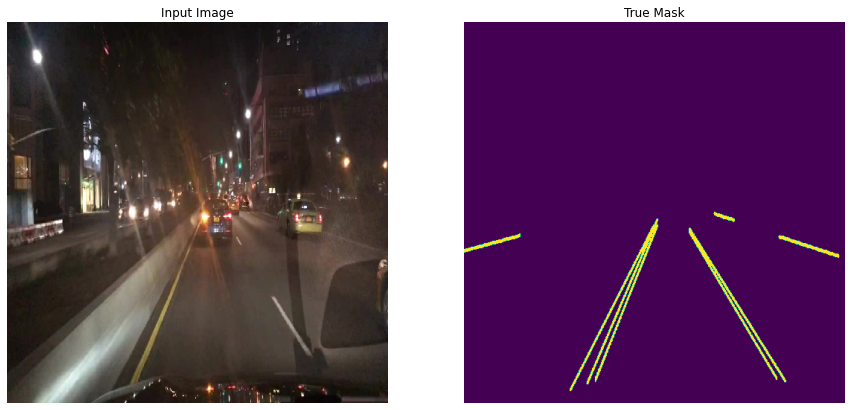

In [28]:
#We will use this sample image during the training procedure
for image, mask in val_dataset.take(1):
    sample_image, sample_mask = image,mask
display([sample_image,sample_mask])

#### Defining the U-Net Model and training it on our data
we have resized our data to 512,512 for training our model

In [11]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [12]:
inputs = layers.Input(shape=(512,512,3))
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8
center = conv_block(encoder4_pool, 1024)
# center
decoder4 = decoder_block(center, encoder4, 512)
# 16
decoder3 = decoder_block(decoder4, encoder3, 256)
# 32
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 25
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [9]:
#load the model
model = models.Model(inputs=[inputs], outputs=[outputs])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
#defining dice coefficient 
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = ((2. * intersection) + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [14]:
#calculation of diceloss
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [15]:
#defining our custom loss using binary cross entropy and dice loss
def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=10e-8), loss=bce_dice_loss, metrics=['accuracy', dice_loss,dice_coeff])

In [16]:
def create_mask(pred_mask):
  new_mask = pred_mask[0]

  for i in range(new_mask.shape[0]):
    for j in range(new_mask.shape[1]):
      if new_mask[i,j] >= 0.5:
        new_mask[i,j] = 1
      else:
        new_mask[i,j] = 0
        
  return new_mask

In [17]:
def show_predictions(model,dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [25]:
#defining callbacks
target_dir = './snapshots'

if not os.path.exists(target_dir):
  os.mkdir(target_dir)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=3,
                                   verbose=2,
                                   min_delta=1e-3,min_lr = 1e-10
                                   )
file_path = 'snapshots/best_weight{epoch:03d}.h5'
checkpoints = tf.keras.callbacks.ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 0, save_best_only = True, mode = 'auto')


In [45]:
EPOCHS = 50
BUFFER_SIZE = 200
BATCH_SIZE = 16
train = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)
val = val_dataset.batch(BATCH_SIZE)

model_history = model.fit(train,
                         epochs=EPOCHS,
                         steps_per_epoch=int(np.ceil(len(X_train)/BATCH_SIZE)),
                         validation_data=val,
                         validation_steps=int(np.ceil(len(X_val)/BATCH_SIZE)),
                         verbose=1,
                         callbacks=[reduce_lr,checkpoints])

Epoch 1/50
25/25 [==============================] - 46s 927ms/step - loss: 1.2216 - accuracy: 0.9618 - dice_loss: 0.9614 - dice_coeff: 0.0386 - val_loss: 1.6700 - val_accuracy: 0.5873 - val_dice_loss: 0.9602 - val_dice_coeff: 0.0398 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 20s 821ms/step - loss: 1.0764 - accuracy: 0.9694 - dice_loss: 0.9295 - dice_coeff: 0.0705 - val_loss: 100.5228 - val_accuracy: 0.0194 - val_dice_loss: 0.9601 - val_dice_coeff: 0.0399 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 20s 819ms/step - loss: 0.9956 - accuracy: 0.9622 - dice_loss: 0.8741 - dice_coeff: 0.1259 - val_loss: 34.7557 - val_accuracy: 0.0505 - val_dice_loss: 0.9593 - val_dice_coeff: 0.0407 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.9383 - accuracy: 0.9644 - dice_loss: 0.8333 - dice_coeff: 0.1667
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
25/25 [==============================] - 20

### Training stats for best model

train loss = 0.7160

val loss = 0.7165

train dice_loss = 0.6418

val dice_loss = 0.6221

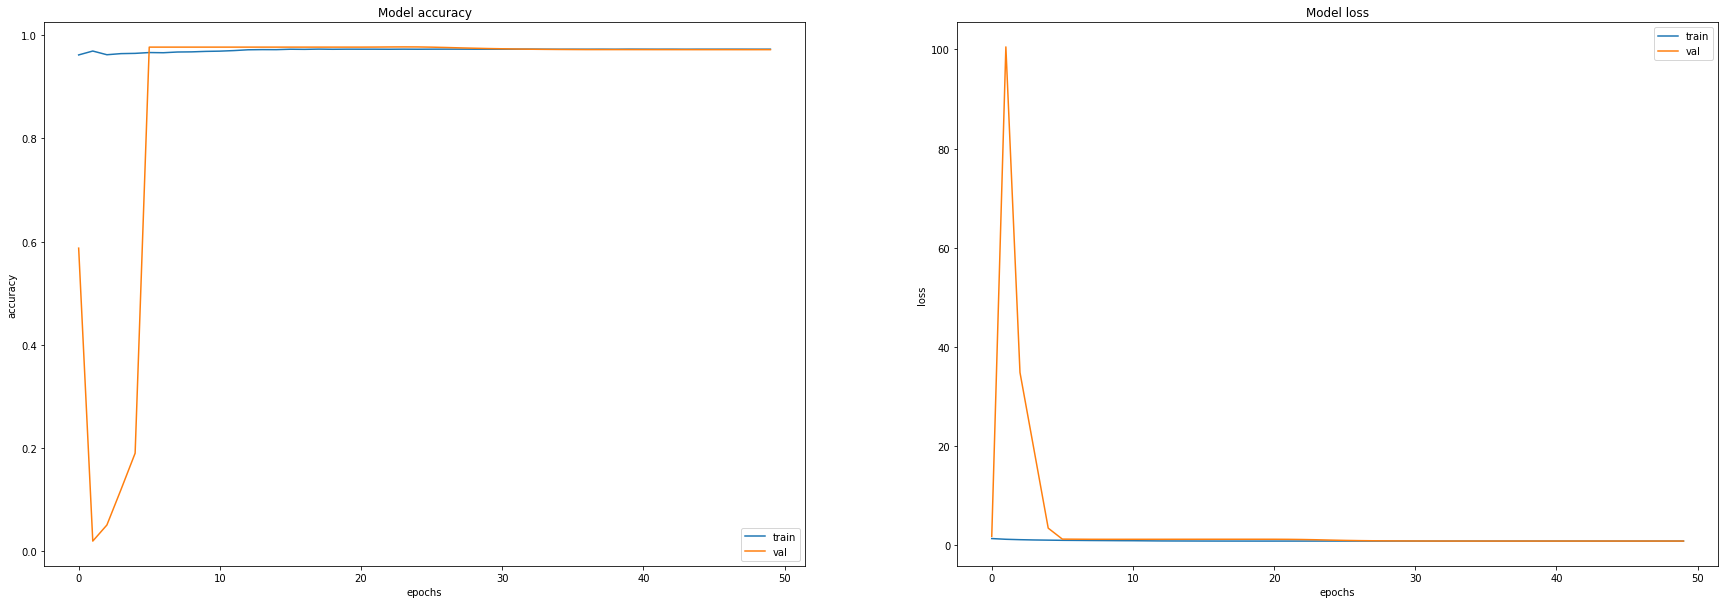

In [46]:
#plotting losses

fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric][:])
    ax[i].plot(model.history.history["val_" + metric][:])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [102]:
from  tensorflow.keras.models import load_model

model = load_model('./snapshots/best_weight039.h5',custom_objects={'bce_dice_loss':bce_dice_loss,'dice_loss':dice_loss,'dice_coeff':dice_coeff})

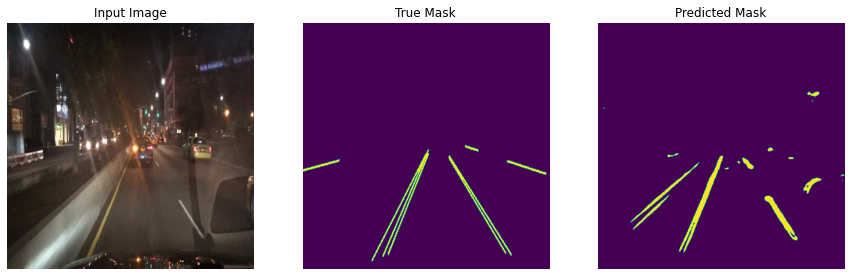

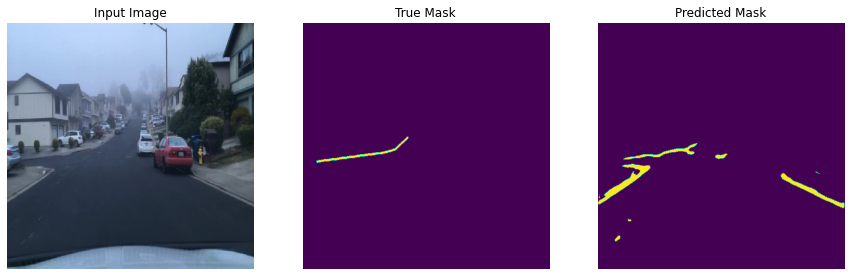

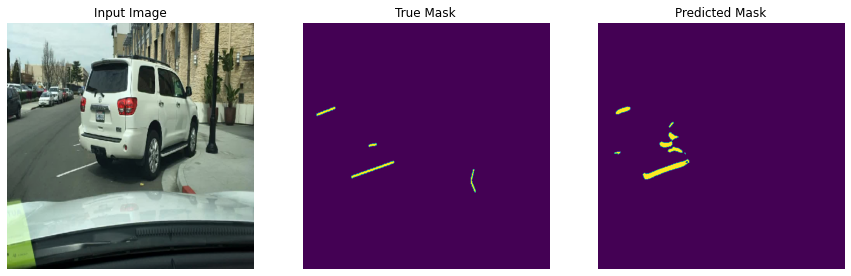

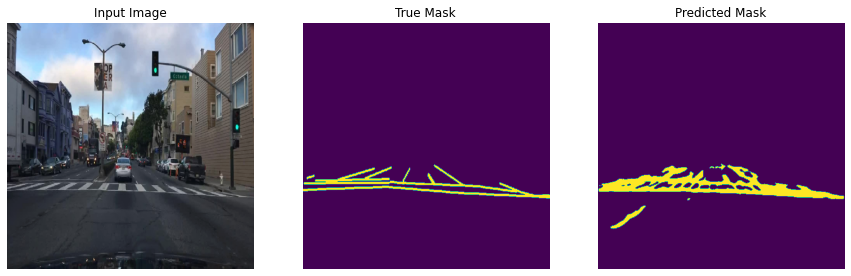

In [59]:
#inference on val set
show_predictions(model,val, 20)

In [60]:
#saving model
model.save('/content/drive/MyDrive/bbdk/normal_1.h5')

In [107]:
#running inference on test set

test_dir = os.listdir('./bddk_dataset/test/images')
for img_name in test_dir:
  image_path = f'./bddk_dataset/test/images/{img_name}'
  #img = load_img(img_path, target_size=(512,512))
  mask_path = f'./bddk_dataset/test/labels/{img_name}'
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image,dtype=tf.float32)
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_jpeg(mask, channels=3)
  mask = mask[:,:,0]
  mask = tf.expand_dims(mask, axis=-1)
  mask = tf.image.convert_image_dtype(mask,dtype=tf.float32)
  input_image = tf.image.resize(image, (512, 512), method='nearest')
  input_mask = tf.image.resize(mask, (512, 512), method='nearest')
  input_image = input_image/ 255.0
  input_image =tf.expand_dims(input_image,axis=0)
 
  pred = model.predict(input_image)

  display([input_image[0],input_mask,create_mask(pred)])

Output hidden; open in https://colab.research.google.com to view.

## using data augmentation

In [57]:
import splitfolders
splitfolders.ratio("lane_detection", output="bddk_dataset_aug", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 1002 files [00:00, 3200.46 files/s]


In [58]:
def augmentator(name, image_arr, mask_arr, no=4):
    
    aug = A.Compose([A.OneOf([A.RandomBrightnessContrast(brightness_limit=[-0.1,0.12], contrast_limit=[-0.08,0.16], brightness_by_max=False,always_apply=True, p=0.6),
                                A.RandomToneCurve(scale=0.2, always_apply=True, p=0.6),
                                A.RGBShift(r_shift_limit=9, g_shift_limit=7, b_shift_limit=10,p=0.6),
                                A.ToGray(p=0.5),
                              A.CLAHE(p=0.6)], p=0.8),
                     
                     A.OneOf([A.CropAndPad(percent=(-0.05, 0.05), p=0.5),
                                  A.Affine(translate_percent={'x': 0.0, 'y': (-0.05, 0.05)}, p=0.45),
                                  A.Affine(translate_percent={'x': (-0.05, 0.05), 'y':0.0}, p=0.4)],
                                 p=0.35)])
                        
    i=0
    while True:
        augment = aug(image= image_arr, mask= mask_arr)

        cv2.imwrite(f'./bddk_dataset_aug/train/images/{name}_aug_{i+1}.jpg', np.clip(augment['image'][:,:,::-1], 0, 255))

        cv2.imwrite(f'./bddk_dataset_aug/train/labels/{name}_aug_{i+1}.jpg', augment['mask'][:,:,::-1])

        i+=1
        if i == no:
            break

In [59]:
train_images = os.listdir('/content/bddk_dataset_aug/train/images')

In [61]:
for image in train_images:
    #print(image)
    img = cv2.imread(os.path.join('/content/bddk_dataset_aug/train/images', image))
    rgb= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(os.path.join('/content/bddk_dataset_aug/train/labels', image))
    
    augmentator(image, rgb, mask)
    #print(image)

In [18]:
train_images = os.listdir('./bddk_dataset_aug/train/images')
val_images=os.listdir('./bddk_dataset_aug/val/images')
test_images = os.listdir('./bddk_dataset_aug/test/images')
print("train data size",len(train_images))
print("val data size",len(val_images))
print("test data size",len(test_images))

train data size 2000
val data size 50
test data size 51


In [85]:
#Setting up the dataset for model training

train_images = os.listdir('./bddk_dataset_aug/train/images')

X_train=[]
y_train=[]

for image in train_images:
    X_train.append(os.path.join('./bddk_dataset_aug/train/images', image))
    y_train.append(os.path.join('./bddk_dataset_aug/train/labels', image))
    
val_images = os.listdir('./bddk_dataset_aug/val/images')
test_images = os.listdir('./bddk_dataset_aug/test/images')
X_val=[]
y_val=[]

for image in val_images:
    X_val.append(os.path.join('./bddk_dataset_aug/val/images', image))
    y_val.append(os.path.join('./bddk_dataset_aug/val/labels', image))
X_test = []
y_test =[]
for image in test_images:
    X_test.append(os.path.join('./bddk_dataset_aug/test/images', image))
    y_test.append(os.path.join('./bddk_dataset_aug/test/labels', image))
train_image_files = tf.constant(X_train)
train_mask_files = tf.constant(y_train)
t_dataset = tf.data.Dataset.from_tensor_slices((train_image_files, train_mask_files))

val_image_files = tf.constant(X_val)
val_mask_files = tf.constant(y_val)
v_dataset = tf.data.Dataset.from_tensor_slices((val_image_files, val_mask_files))



In [86]:
test_image_files = tf.constant(X_test)
test_mask_files = tf.constant(y_test)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_files, test_mask_files))

In [87]:
processed_trainset = t_dataset.map(process_path)
train_dataset = processed_trainset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
processed_val_set = v_dataset.map(process_path)
val_dataset = processed_val_set.map(load_image_test)

In [90]:
processed_test_set = test_dataset.map(process_path)
test_dataset = processed_test_set.map(load_image_test)

In [26]:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=10e-8), loss=bce_dice_loss, metrics=['accuracy', dice_loss,dice_coeff])

In [28]:
target_dir = './snapshots2'

if not os.path.exists(target_dir):
  os.mkdir(target_dir)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=3,
                                   verbose=2,
                                   min_delta=1e-3,min_lr = 1e-10
                                   )
file_path = 'snapshots2/best_weight{epoch:03d}.h5'
checkpoints = tf.keras.callbacks.ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 0, save_best_only = True, mode = 'auto')


In [29]:
EPOCHS = 50
BUFFER_SIZE = 200
BATCH_SIZE = 12
train = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)
val = val_dataset.batch(BATCH_SIZE)

model_history = model.fit(train,
                         epochs=EPOCHS,
                         steps_per_epoch=int(np.ceil(len(X_train)/BATCH_SIZE)),
                         validation_data=val,
                         validation_steps=int(np.ceil(len(X_val)/BATCH_SIZE)),
                         verbose=1,
                         callbacks=[reduce_lr,checkpoints])

Epoch 1/50
167/167 [==============================] - 131s 649ms/step - loss: 1.1363 - accuracy: 0.9615 - dice_loss: 0.9597 - dice_coeff: 0.0403 - val_loss: 1.0735 - val_accuracy: 0.9770 - val_dice_loss: 0.9749 - val_dice_coeff: 0.0251 - lr: 0.0010
Epoch 2/50
167/167 [==============================] - 102s 608ms/step - loss: 0.9435 - accuracy: 0.9650 - dice_loss: 0.8436 - dice_coeff: 0.1564 - val_loss: 1.2857 - val_accuracy: 0.8065 - val_dice_loss: 0.9571 - val_dice_coeff: 0.0429 - lr: 0.0010
Epoch 3/50
167/167 [==============================] - 103s 615ms/step - loss: 0.7912 - accuracy: 0.9683 - dice_loss: 0.7027 - dice_coeff: 0.2973 - val_loss: 1.1187 - val_accuracy: 0.9770 - val_dice_loss: 0.9971 - val_dice_coeff: 0.0029 - lr: 0.0010
Epoch 4/50
167/167 [==============================] - ETA: 0s - loss: 0.7316 - accuracy: 0.9706 - dice_loss: 0.6450 - dice_coeff: 0.3550
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
167/167 [==========================

### Model performance metrics 
train loss 0.579

train dice losss 0.5066

val loss 0.6122

val dice loss  0.5235

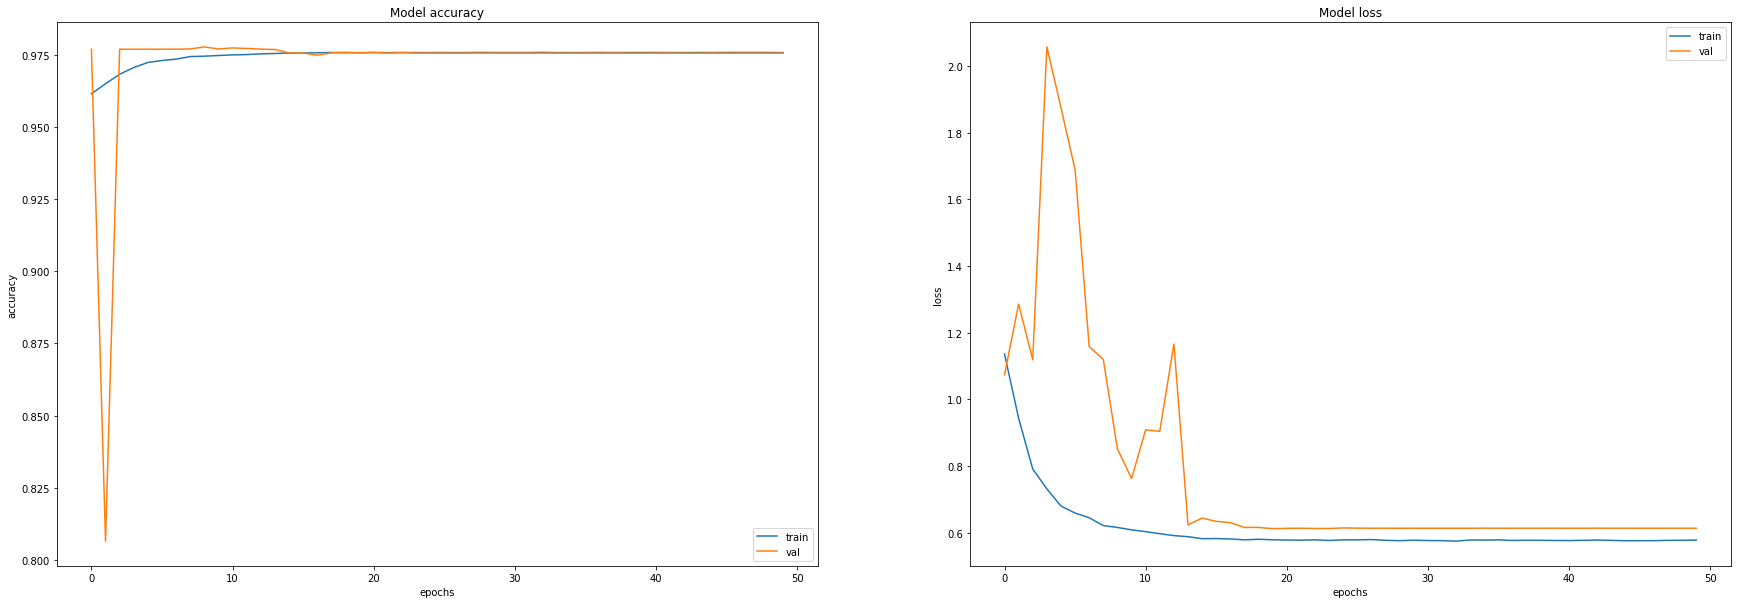

In [116]:
#plotting losses

fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model_history.history[metric][:])
    ax[i].plot(model_history.history["val_" + metric][:])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [37]:
#loading the best model
from  tensorflow.keras.models import load_model

model = load_model('./snapshots2/best_weight020.h5',custom_objects={'bce_dice_loss':bce_dice_loss,'dice_loss':dice_loss,'dice_coeff':dice_coeff})

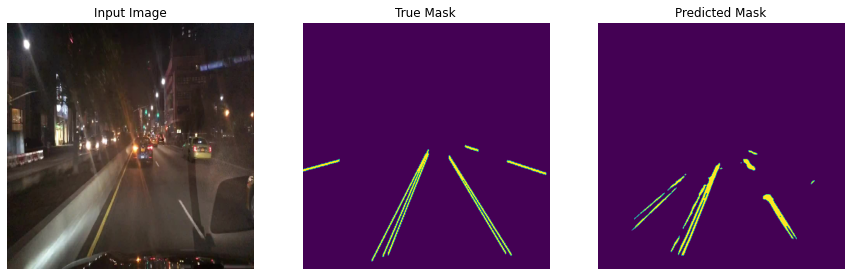

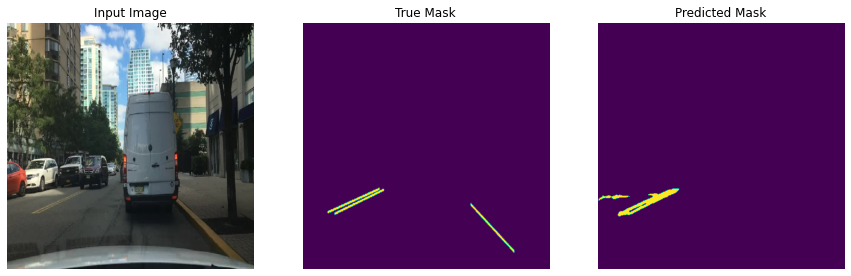

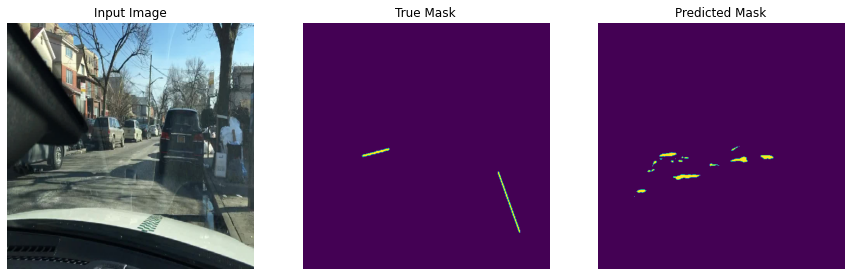

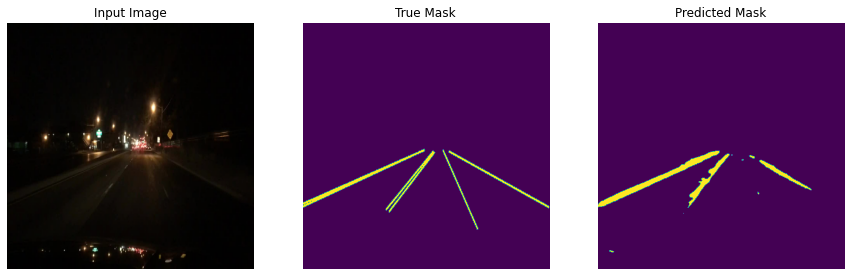

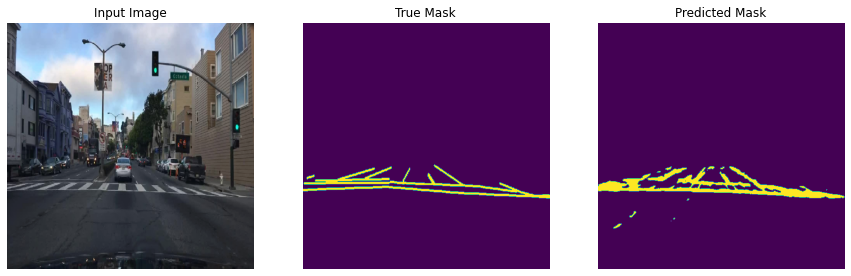

In [69]:
#run inference on val set
show_predictions(model,val, 20)

In [56]:
model.save('/content/drive/MyDrive/lane_aug.h5')

In [108]:
#running inference on test set

test_dir = os.listdir('./bddk_dataset_aug/test/images')
for img_name in test_dir:
  image_path = f'./bddk_dataset_aug/test/images/{img_name}'
  #img = load_img(img_path, target_size=(512,512))
  mask_path = f'./bddk_dataset_aug/test/labels/{img_name}'
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image,dtype=tf.float32)
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_jpeg(mask, channels=3)
  mask = mask[:,:,0]
  mask = tf.expand_dims(mask, axis=-1)
  mask = tf.image.convert_image_dtype(mask,dtype=tf.float32)
  input_image = tf.image.resize(image, (512, 512), method='nearest')
  input_mask = tf.image.resize(mask, (512, 512), method='nearest')
  input_image = input_image/ 255.0
  input_image =tf.expand_dims(input_image,axis=0)
 
  pred = model.predict(input_image)

  display([input_image[0],input_mask,create_mask(pred)])

Output hidden; open in https://colab.research.google.com to view.